In [2]:
%cd ./drive/MyDrive/Github/Anime/animeface_dataset/animeface-character-dataset/thumb/

/content/drive/MyDrive/Github/Anime/animeface_dataset/animeface-character-dataset/thumb


In [3]:
import os 
from glob import glob 
import numpy as np 
from PIL import Image 
import torch, torchvision 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.models import vgg19 
from torch.utils.data import DataLoader 
from sklearn.metrics import classification_report
from torch.utils.tensorboard import summary 
import matplotlib.pyplot as plt
import json 
from tqdm import tqdm 

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(0)
np.random.seed(0)

cuda:0


In [37]:
class Transform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                                         transforms.RandomResizedCrop(resize, scale=(.5, 1.0)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)
            ]), 
            "val": transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, phase, img):
        return self.data_transform[phase](img)

class MyDataSet(object):
    def __init__(self, resize, mean, std):
        self.files = []
        self.labels = []
        self.label2index = {}
        self.transform = Transform(resize, mean, std)

        self._load()
        self._vocab()

    def _load(self):
        root_path = "thumb/*/"
        for root in glob(root_path)[:5]:
            for f in glob(root+"*.png"):
                label = f.split("/")[1].split("_")[-1]
                self.files.append(f)
                self.labels.append(label)
                if label not in self.label2index:
                    self.label2index[label] = len(self.label2index)

    def _vocab(self):
        labels = []
        for l in self.labels:
            labels.append(self.label2index[l])
        self.labels = labels 

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        label = self.labels[idx]
        img_tensor = self.transform("train", img)
        label_tensor = torch.tensor(label)
        return img_tensor, label_tensor 

    def __len__(self):
        return len(self.files)


RESIZE = 224 
MEAN = (.485, .456, .406)
STD = (.229, .224, .225)
mydata = MyDataSet(RESIZE, MEAN, STD)

In [42]:
with open("labels.json", "w") as f:
    json.dump(mydata.label2index, f)

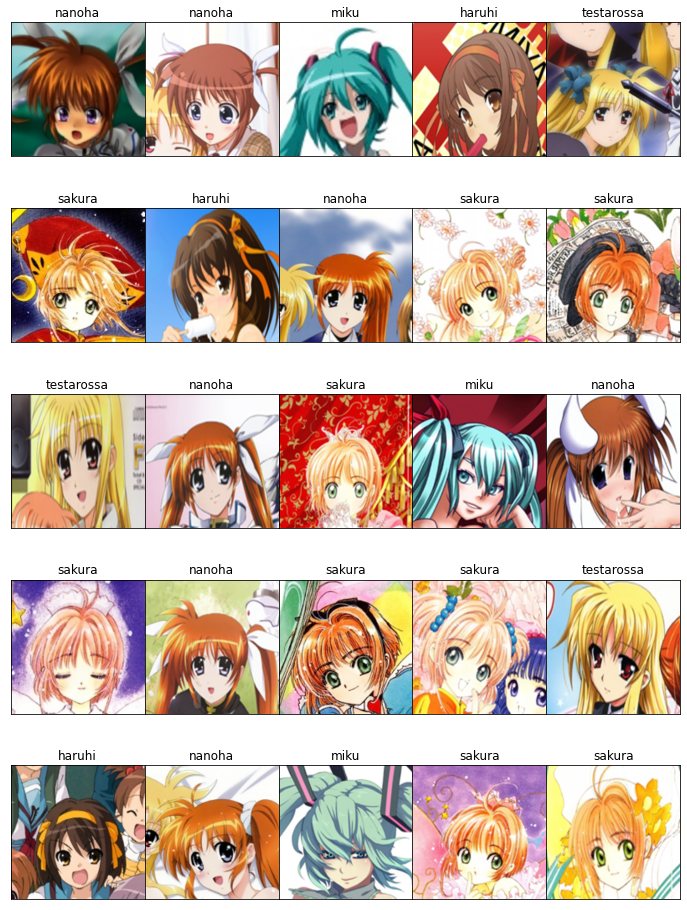

In [41]:
def show_img(img_file):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    ax = axes.ravel()
    for i in range(25):
        a = np.random.randint(0, len(img_file), 1)[0]
        img = Image.open(img_file[a]).resize((1080, 1080))
        name = img_file[a].split("/")[1].split("_")[-1]
        ax[i].imshow(img)
        ax[i].set_title(name)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0, top=1.2)
    plt.show()

show_img(mydata.files)

In [43]:
train_dl = DataLoader(dataset=mydata, batch_size=32, shuffle=True, drop_last=True)

In [44]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.vgg = vgg19(pretrained=True)
        for w in self.vgg.parameters():
            w.requires_grad = False 
        self.fc = nn.Linear(1000, n_classes)

    def forward(self, x):
        y = self.vgg(x)
        y = self.fc(y)
        return y 
net = Classifier(len(mydata.label2index))

In [45]:
def trainer(img, label, net, criterion, optimizer):
    output = net(img)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def show_losses(losses):
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(losses)).tolist(), losses)
    plt.title("vgg19 train losses")
    plt.show()

def train(train, net, num_epoch, print_loss=100, plot_loss=150, lr=0.001):
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    show_plot_loss = []

    for e in range(num_epoch):
        net.train()
        print_losses, plot_losses, total_loss = [], [], []
        for i, (img, label) in enumerate(tqdm(train)):
            img = img.to(device)
            label = label.to(device)
            loss = trainer(img, label, net, criterion, optimizer)
      
            total_loss.append(loss)
            print_losses.append(loss)
            plot_losses.append(loss)

            if i%print_loss==0:
                a = np.mean(np.array(print_losses))
                print("\n")
                print(f"iteration:{i} | train | loss{a:.5f}\n")
                print_losses = []
            if i%plot_loss==0:
                show_plot_loss.append(np.mean(np.array(plot_losses)))
                plot_losses = []

        print(f"epoch: {e+1} | train | loss:{np.mean(np.array(total_loss))}\n")
        total_loss = []
    
    show_losses(show_plot_loss)
    os.makedirs("models", exist_ok=True)
    torch.save(net.state_dict(), f"models/classifier{num_epoch}.pth")

  7%|▋         | 1/15 [00:05<01:21,  5.79s/it]



iteration:0 | train | loss3.64408



100%|██████████| 15/15 [01:16<00:00,  5.12s/it]


epoch: 1 | train | loss:1.754730761051178



  7%|▋         | 1/15 [00:00<00:13,  1.03it/s]



iteration:0 | train | loss1.04466



100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch: 2 | train | loss:0.8448832333087921



  7%|▋         | 1/15 [00:00<00:07,  1.88it/s]



iteration:0 | train | loss1.27479



100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


epoch: 3 | train | loss:0.6409197986125946



  7%|▋         | 1/15 [00:00<00:07,  1.90it/s]



iteration:0 | train | loss0.36186



100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


epoch: 4 | train | loss:0.5131181001663208



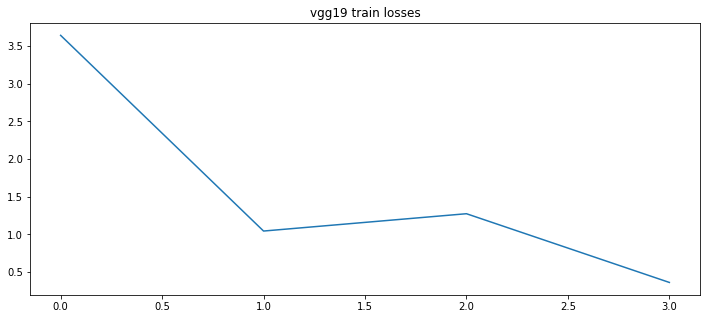

In [46]:
train(train_dl, net, 4)

In [63]:
def load_model():
    net = Classifier(len(mydata.label2index))
    net.load_state_dict(torch.load("./models/classifier4.pth", map_location={"cuda:0": "cpu"}))
    net.eval()
    net.to(device)
    transform = Transform(RESIZE, MEAN, STD)
    return net, transform 

def load_label():
    with open("labels.json", "r") as f:
        label2index = json.load(f)
        f.close()
    index2label = {v: k for k, v in label2index.items()}
    return index2label  

def show_img(img):
    plt.imshow(img.resize((1080, 1080)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

def main(img_path: str):
    # モデルの読み込み
    index2label = load_label()
    net, transform = load_model()
    # 画像の前処理
    img = Image.open(img_path)
    show_img(img)
    img_tensor = transform("val", img).unsqueeze(0).to(device)
    # 推論
    with torch.no_grad():
        output = net(img_tensor)
        output = nn.Softmax(dim=1)(output)
        pred = output.topk(3)[0][0].detach().cpu().numpy().tolist() # 確率
        pred_id = output.topk(3)[1][0].detach().cpu().numpy().tolist() # index 
    # ラベル名と確率
    results = {}
    for i, (p, idx) in enumerate(zip(pred, pred_id)):
        pred_name = index2label[int(idx)]
        result = {}
        result["score"] = p 
        result["predict"] = pred_name 
        results[str(i+1)] = result
    return results  
    

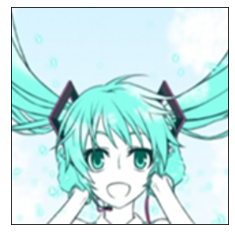

{'1': {'predict': 'sakura', 'score': 0.8871161937713623},
 '2': {'predict': 'nanoha', 'score': 0.09861434251070023},
 '3': {'predict': 'miku', 'score': 0.011321764439344406}}

In [64]:
sample = ["1.png", "2.png", "3.png"] 
sample = ["img/"+p for p in sample]
main(sample[0])

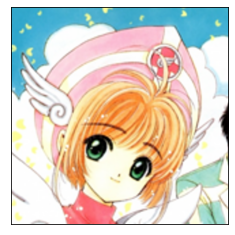

{'1': {'predict': 'sakura', 'score': 0.9998718500137329},
 '2': {'predict': 'haruhi', 'score': 4.8267065722029656e-05},
 '3': {'predict': 'miku', 'score': 3.8434911402873695e-05}}

In [51]:
main(sample[1])

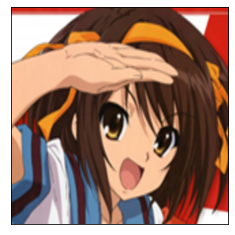

{'1': {'predict': 'haruhi', 'score': 0.9999786615371704},
 '2': {'predict': 'miku', 'score': 2.062032035610173e-05},
 '3': {'predict': 'sakura', 'score': 4.798452550858201e-07}}

In [52]:
main(sample[2])

In [53]:
!pip install -q lime==0.2.0.1

     |████████████████████████████████| 275 kB 5.3 MB/s eta 0:00:01


In [70]:
from lime.wrappers.scikit_image import SegmentationAlgorithm 
from skimage.segmentation import mark_boundaries
from lime import lime_image
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import uuid 
import os 

# from predict import load_model 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# net = Classifier(len(mydata.label2index))
net, transform = load_model()

def predict_fn(img):
    '''モデルの予測を確立で返す'''
    img_tensor = torch.stack(tuple(transform("val", i) for i in img), dim=0)
    img_tensor = img_tensor.to(device)
    net.to(device)
    output = net(img_tensor)
    proba = torch.nn.functional.softmax(output, dim=1)
    return proba.detach().cpu().numpy()

def show_boundary(img_path: str, num_samples: int=400, show_idx: int=0):
    """指定されたラベルにおける寄与を出力する"""
    img = Image.open(img_path).resize((224, 224))
    segmentaion_fn = SegmentationAlgorithm("quickshift", kernel_size=4, 
                                           max_dist=200, ratio=.2, random_state=0)
    segments = segmentaion_fn(img)
    explainer = lime_image.LimeImageExplainer(random_state=0)
    exp = explainer.explain_instance(np.array(img), predict_fn, top_labels=2, hide_color=0, 
                                    num_samples=num_samples, segmentation_fn=segmentaion_fn)
    class_index: int = exp.top_labels[show_idx]
    index2label: Dict[int, str] = load_label()
    image, mask = exp.get_image_and_mask(class_index, positive_only=False, num_features=5, hide_rest=False)
    img_boundary = mark_boundaries(image, mask)

    id = uuid.uuid4()
    os.makedirs("results", exist_ok=True)
    fig = plt.figure()
    plt.imshow(img_boundary)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{index2label[int(class_index)]}")
    plt.show()
    fig.savefig(f"results/img{str(id)[:4]}.png")

def show_ratio(img_path: str, num_samples: int=200, show_idx: int=0):
    """指定されたラベルの降順に寄与を出力する"""
    img = Image.open(img_path).resize((224, 224))
    segmentaion_fn = SegmentationAlgorithm("quickshift", kernel_size=4, 
                                           max_dist=200, ratio=.2, random_state=0)
    segments = segmentaion_fn(img)
    explainer = lime_image.LimeImageExplainer(random_state=0)
    exp = explainer.explain_instance(np.array(img), predict_fn, top_labels=2, hide_color=0, 
                                    num_samples=num_samples, segmentation_fn=segmentaion_fn)
    class_index = exp.top_labels[show_idx]
    index2label: Dict[int, str] = load_label()

    fig, axes = plt.subplots(2, 2, figsize=(9, 9))
    ax = axes.ravel()
    plt.subplots_adjust(top=1.1, wspace=0, hspace=0)
    for i in range(4):
        area_index, value = exp.local_exp[class_index][i]
        img = exp.image.copy()
        c = 0 if value < 0 else 1
        img[segments == area_index, c] = np.max(img)
        ax[i].imshow(img)
        ax[i].set_title(f"{index2label[class_index]} ratio: {value:.5f}")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()
    os.makedirs("results", exist_ok=True)
    id = uuid.uuid4()
    fig.savefig(f"results/img{str(id)[:4]}.png")



  0%|          | 0/10 [00:00<?, ?it/s]

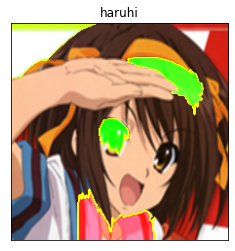

In [72]:
show_boundary(sample[2], num_samples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

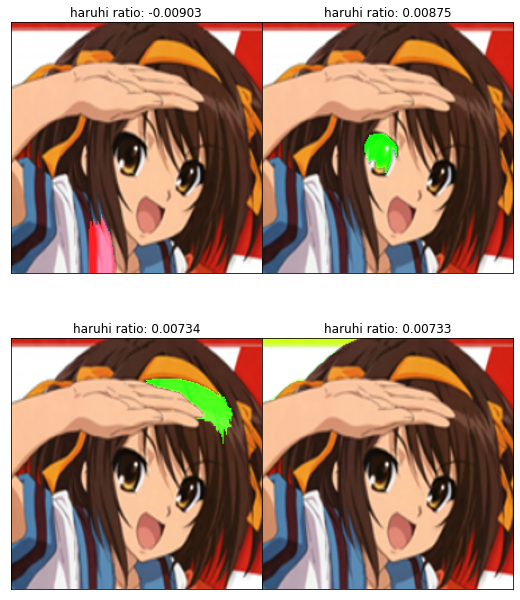

In [73]:
show_ratio(sample[2], num_samples=10)